In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(brms)
    library(gtools)
    library(visdat)
    library(parallel)
    library(ggridges)
})

In [27]:
source("../functions/utils.R")

In [3]:
dec <- readRDS("../data/prepped_data/zctas_decennial.rds")
acs_5_zcta <- readRDS("../data/prepped_data/zctas_acs.rds")
acs_1_state <- read_csv("../data/acs/state_acs_1yr_2005_2018_long.csv")
names(dec) <- sub("_$", "", names(dec))
names(acs_5_zcta) <- sub("_$", "", names(acs_5_zcta))
names(acs_1_state) <- sub("_$", "", names(acs_1_state))

Parsed with column specification:
cols(
  .default = col_double(),
  stateid = col_character()
)

See spec(...) for full column specifications.



In [4]:
state_avg <- acs_1_state %>%
    filter(year %in% c(2013, 2018)) %>%
    select(-one_of("area_sqmi", "geoid", "year", "chh", "chh_moe")) %>%
    group_by(stateid) %>%
    summarize_all(funs(mean(., na.rm = TRUE)))
head(state_avg)

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


stateid,medhhinc,pown,pfemale,page_1824,page_under18,page_65plus,pnw,pblack,phisp,⋯,pmoved_fromabroad,pmoved,punemployed,ppost2010_2015,ppost2010_2016,ppost2010_2017,ppov,ppost2000,ppost2010_2018,chh_density
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01,46355.0,0.6804054,0.5153949,0.09874125,0.2262161,0.1595054,0.3419844,0.26526935,0.04128040,⋯,0.00309055,0.1412618,0.07627305,0.0403324,0.0528370,0.0631478,0.1680208,0.2245393,0.0739738,36.30764
02,73291.5,0.6455120,0.4775371,0.10373470,0.2525073,0.1042730,0.3871266,0.03298175,0.06896995,⋯,0.00829375,0.1764857,0.07780730,0.0291676,0.0385262,0.0410704,0.1090628,0.2155444,0.0551088,0.43860
04,53878.0,0.6343763,0.5025916,0.09830650,0.2364080,0.1646494,0.4454972,0.04149630,0.30929935,⋯,0.00618125,0.1760519,0.07138570,0.0313635,0.0468884,0.0622993,0.1402305,0.3033029,0.0702701,22.07469
05,43786.5,0.6574150,0.5080809,0.09629945,0.2370203,0.1608526,0.2713023,0.15333280,0.07252380,⋯,0.00302995,0.1481078,0.06288470,0.0427219,0.0577767,0.0728825,0.1724536,0.2412792,0.0839343,21.92972
06,67733.5,0.5430274,0.5025531,0.09979385,0.2332427,0.1341681,0.6226273,0.05581395,0.38842230,⋯,0.00744965,0.1357353,0.07789600,0.0196668,0.0272620,0.0347151,0.1280145,0.1502939,0.0414703,82.56148
08,65388.0,0.6482442,0.4973903,0.09506770,0.2290131,0.1321287,0.3154672,0.03832225,0.21362510,⋯,0.00661915,0.1850758,0.05480090,0.0363983,0.0530259,0.0679821,0.0963762,0.2527189,0.0827625,20.16347


In [5]:
dec_c <- dec %>%
    select(zcta_id, ig_count_imptd, chh, state_fips) %>%
    rename("stateid" = "state_fips") %>%
    mutate("stateid" = str_pad(as.character(stateid), width = 2, side = "left", pad = "0")) %>%
    left_join(state_avg, by = "stateid") 
head(dec_c)

zcta_id,ig_count_imptd,chh,stateid,medhhinc,pown,pfemale,page_1824,page_under18,page_65plus,⋯,pmoved_fromabroad,pmoved,punemployed,ppost2010_2015,ppost2010_2016,ppost2010_2017,ppov,ppost2000,ppost2010_2018,chh_density
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01001,7923,7215,25,73301.5,0.6164816,0.5147761,0.1028019,0.2030996,0.1563719,⋯,0.0092599,0.1295039,0.0626684,0.018372,0.0268995,0.0331011,0.0996114,0.1086845,0.0408889,330.8064
01002,9533,9910,25,73301.5,0.6164816,0.5147761,0.1028019,0.2030996,0.1563719,⋯,0.0092599,0.1295039,0.0626684,0.018372,0.0268995,0.0331011,0.0996114,0.1086845,0.0408889,330.8064
01005,1866,1904,25,73301.5,0.6164816,0.5147761,0.1028019,0.2030996,0.1563719,⋯,0.0092599,0.1295039,0.0626684,0.018372,0.0268995,0.0331011,0.0996114,0.1086845,0.0408889,330.8064
01007,5415,5595,25,73301.5,0.6164816,0.5147761,0.1028019,0.2030996,0.1563719,⋯,0.0092599,0.1295039,0.0626684,0.018372,0.0268995,0.0331011,0.0996114,0.1086845,0.0408889,330.8064
01008,444,503,25,73301.5,0.6164816,0.5147761,0.1028019,0.2030996,0.1563719,⋯,0.0092599,0.1295039,0.0626684,0.018372,0.0268995,0.0331011,0.0996114,0.1086845,0.0408889,330.8064
01009,347,315,25,73301.5,0.6164816,0.5147761,0.1028019,0.2030996,0.1563719,⋯,0.0092599,0.1295039,0.0626684,0.018372,0.0268995,0.0331011,0.0996114,0.1086845,0.0408889,330.8064


### Modelling

In [10]:
n_cores <- detectCores() - 1
n_cores

[1] 7

In [12]:
desc1 <- "Bayesian random slopes with covariates"
f1 <- formula(log(chh) ~ 1 + log(ig_count_imptd) + (1 + log(ig_count_imptd) | stateid) +
              pown + pfemale + page_1824 + page_under18 + page_65plus + pnw + pblack + 
              phisp + pasian + pnative + pvacant + phu_othervacant + pgq)
formulas <- list(f1)

In [13]:
my_prior <- c(
    set_prior("normal(0, 5)", class = "Intercept"),
    set_prior("normal(0, 5)", class = "b"),
    set_prior("student_t(3, 0, 5)", class = "sd"),
    set_prior("lkj(2)", class = "cor")
)

In [14]:
print(make_stancode(f1, dec_c, prior = my_prior))

// generated with brms 2.14.4
functions {
  /* turn a vector into a matrix of defined dimension 
   * stores elements in row major order
   * Args: 
   *   X: a vector 
   *   N: first dimension of the desired matrix
   *   K: second dimension of the desired matrix 
   * Returns: 
   *   a matrix of dimension N x K 
   */ 
  matrix as_matrix(vector X, int N, int K) { 
    matrix[N, K] Y; 
    for (i in 1:N) {
      Y[i] = to_row_vector(X[((i - 1) * K + 1):(i * K)]); 
    }
    return Y; 
  } 
 /* compute correlated group-level effects
  * Args: 
  *   z: matrix of unscaled group-level effects
  *   SD: vector of standard deviation parameters
  *   L: cholesky factor correlation matrix
  * Returns: 
  *   matrix of scaled group-level effects
  */ 
  matrix scale_r_cor(matrix z, vector SD, matrix L) {
    // r is stored in another dimension order than z
    return transpose(diag_pre_multiply(SD, L) * z);
  }
}
data {
  int<lower=1> N;  // total number of observations
  vector[N] Y;  // r

In [15]:
models <- fit_models(
    formulas, 
    dec_c, 
    "../models/zcta/zcta_state_covs.rds", 
    cores = n_cores,
    prior = my_prior,
    chains = 6,
    iter = 6000,
    warmup = 1000,
    thin = 3
)

Fitting model 1



Compiling Stan program...

Start sampling

Warning message:
“There were 538 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


Model fit complete. Runtime:  4.443533

In [16]:
summary(models[[1]])

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log(chh) ~ 1 + log(ig_count_imptd) + (1 + log(ig_count_imptd) | stateid) + pown + pfemale + page_1824 + page_under18 + page_65plus + pnw + pblack + phisp + pasian + pnative + pvacant + phu_othervacant + pgq 
   Data: data (Number of observations: 32369) 
Samples: 6 chains, each with iter = 6000; warmup = 1000; thin = 3;
         total post-warmup samples = 10000

Group-Level Effects: 
~stateid (Number of levels: 51) 
                                 Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                        0.40      0.04     0.33     0.50 1.00
sd(logig_count_imptd)                0.04      0.00     0.04     0.05 1.00
cor(Intercept,logig_count_imptd)    -0.99      0.00    -1.00    -0.98 1.00
                                 Bulk_ESS Tail_ESS
sd(Intercept)                        4650     6993
sd(logig_count_imptd)                4758     7293
cor(Intercept,logig_count_imptd)     6869     9120

Popu

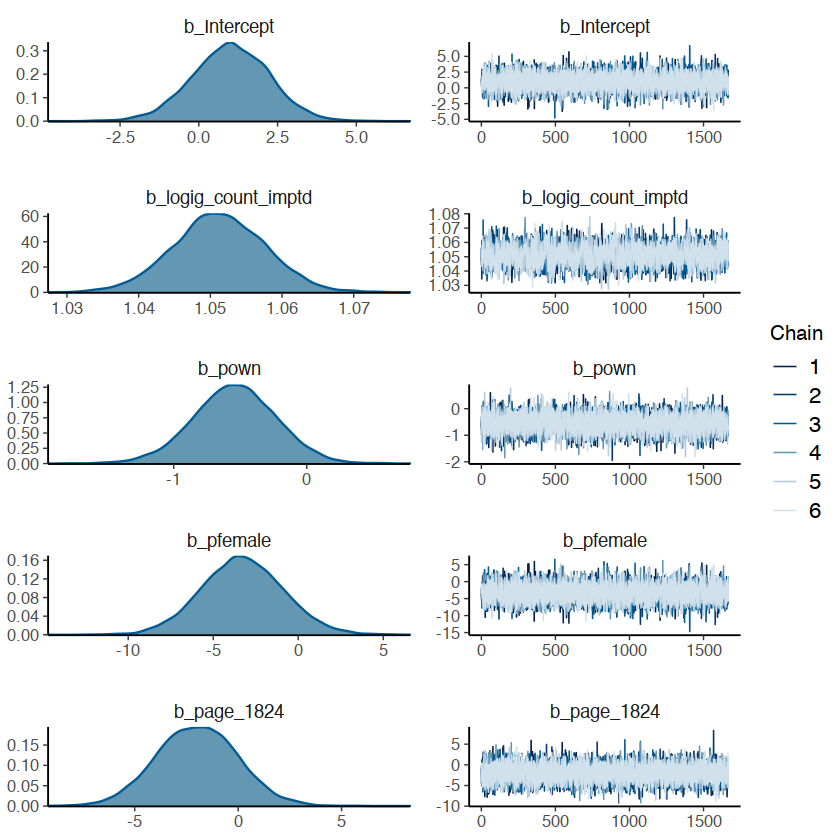

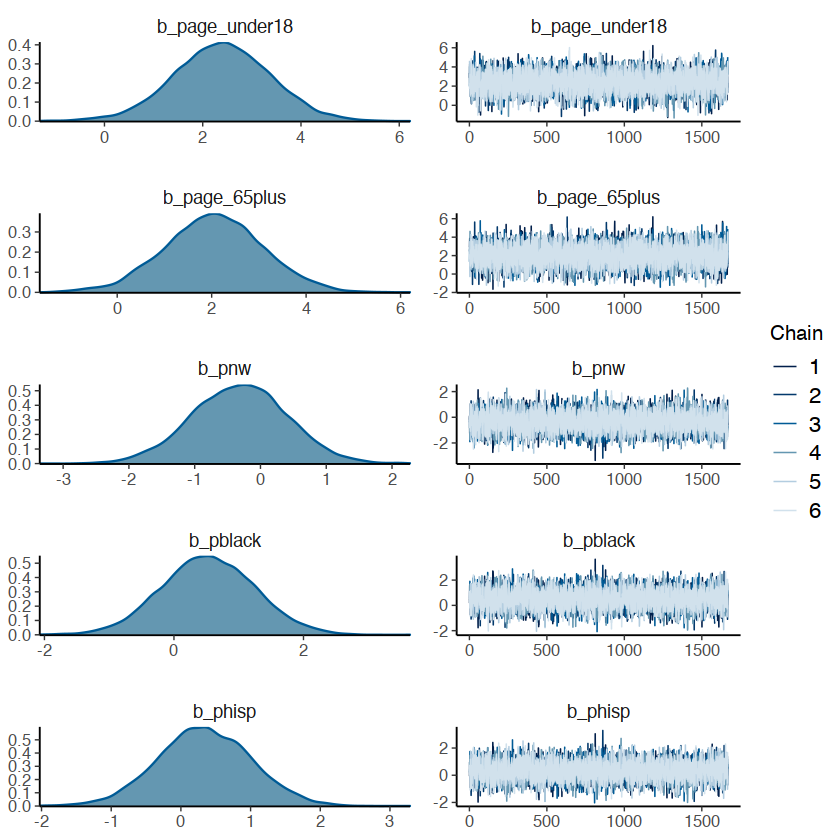

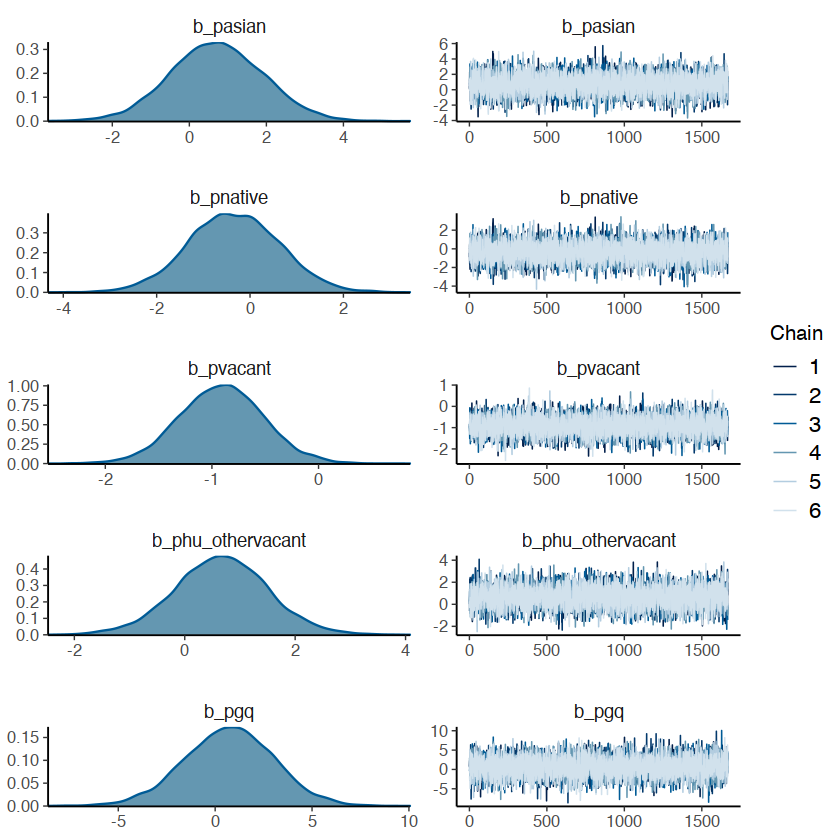

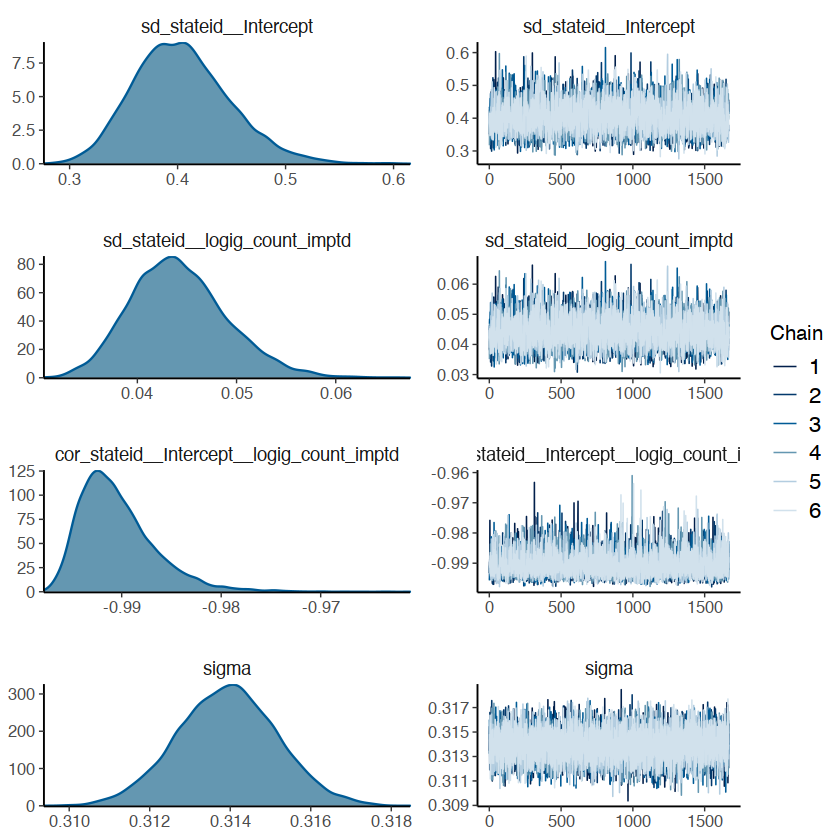

In [18]:
plot(models[[1]])

In [24]:
years <- unique(acs_5_zcta$year)
years

[1] "2006" "2007" "2008" "2009" "2010" "2011" "2012" "2013" "2014" "2015"
[11] "2016" "2017" "2018" "2019"

Warning message:
“Unknown or uninitialised column: `year`.”


NULL

In [28]:
# This also takes a while, can read in below from a saved file
projections <- proj_by_year(acs_5_zcta, dec_c, models, "zcta_id", n_samples = 5000)

predictions for 2006

Warning message:
“Unknown columns: `year`”
predictions for 2007

Warning message:
“Unknown columns: `year`”
predictions for 2008

Warning message:
“Unknown columns: `year`”
predictions for 2009

Warning message:
“Unknown columns: `year`”
predictions for 2010

Warning message:
“Unknown columns: `year`”
predictions for 2011

Warning message:
“Unknown columns: `year`”
predictions for 2012

Warning message:
“Unknown columns: `year`”
predictions for 2013

Warning message:
“Unknown columns: `year`”
predictions for 2014

Warning message:
“Unknown columns: `year`”
predictions for 2015

Warning message:
“Unknown columns: `year`”
predictions for 2016

Warning message:
“Unknown columns: `year`”
predictions for 2017

Warning message:
“Unknown columns: `year`”
predictions for 2018

Warning message:
“Unknown columns: `year`”
predictions for 2019

Warning message:
“Unknown columns: `year`”


In [34]:
projections$year <- as.numeric(projections$year)
projections$lig <- log(projections$ig_count_imptd)
projections_w_5year <- get_fiveyear(
    projections, 
    c("lprd_1", "prd_1", "ig_count_imptd", "lig", "lu90_1", "ll90_1", "u90_1", "l90_1"), 
    "zcta_id"
)

Averaging for 2010

Averaging for 2011

Averaging for 2012

Averaging for 2013

Averaging for 2014

Averaging for 2015

Averaging for 2016

Averaging for 2017

Averaging for 2018



In [35]:
# Note that moving forward, a year actually represents the average 
# of the year and the previous four years
years <- c(2011:2018)
projections_w_5year$lig_5year <- log(projections_w_5year$ig_count_imptd_5year)
log_errs_raw <- get_errors_by_year(projections_w_5year, years, "lig_5year")
log_errs_raw

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2011,6.989282,1.770551,7.025790,1.660158,0.9807195,0.9618108,0.3561761,0.2040748,0.1171862
errors_2012,6.988715,1.775456,7.033224,1.652361,0.9806387,0.9616523,0.3615653,0.2029685,0.1162751
errors_2013,6.988990,1.779193,7.045167,1.647164,0.9804983,0.9613770,0.3672705,0.2027163,0.1130374
errors_2014,6.988852,1.783051,7.055275,1.647193,0.9802940,0.9609763,0.3723163,0.2036328,0.1117222
errors_2015,6.989012,1.786711,7.059900,1.653760,0.9809036,0.9621719,0.3681698,0.2004695,0.1089585
errors_2016,6.990491,1.791657,7.064294,1.660733,0.9806547,0.9616836,0.3710886,0.2004252,0.1071606
errors_2017,6.993471,1.799474,7.065473,1.671089,0.9800222,0.9604435,0.3765802,0.2029870,0.1079325
errors_2018,6.994283,1.805109,7.067154,1.683737,0.9799340,0.9602707,0.3768439,0.2027757,0.1060184


In [36]:
log_errs_adj <- get_errors_by_year(projections_w_5year, years, "lprd_1_5year")
log_errs_adj

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2011,6.989282,1.770551,7.010557,1.742331,0.9819243,0.9641752,0.3358105,0.1873976,0.10183826
errors_2012,6.988715,1.775456,7.019441,1.733548,0.9819083,0.9641439,0.3377329,0.1848962,0.09943608
errors_2013,6.988990,1.779193,7.032105,1.728408,0.9817861,0.9639039,0.3412568,0.1843649,0.09840892
errors_2014,6.988852,1.783051,7.043518,1.728282,0.9814920,0.9633265,0.3464874,0.1858624,0.10011362
errors_2015,6.989012,1.786711,7.048251,1.736241,0.9817968,0.9639250,0.3449514,0.1853016,0.10090003
errors_2016,6.990491,1.791657,7.052582,1.744729,0.9812557,0.9628628,0.3510575,0.1883784,0.10212755
errors_2017,6.993471,1.799474,7.053607,1.756167,0.9805181,0.9614157,0.3586373,0.1931576,0.10502810
errors_2018,6.994283,1.805109,7.055179,1.770201,0.9802006,0.9607932,0.3625701,0.1966423,0.10770181


In [37]:
round((log_errs_adj$med_ad - log_errs_raw$med_ad)/log_errs_raw$med_ad, 3)

[1] -0.131 -0.145 -0.129 -0.104 -0.074 -0.047 -0.027  0.016

In [38]:
round((log_errs_adj$rmse - log_errs_raw$rmse)/log_errs_raw$rmse, 3)

[1] -0.057 -0.066 -0.071 -0.069 -0.063 -0.054 -0.048 -0.038